# kNN metod

In [1]:
import cv2
import mediapipe as mp
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.data import Dataset

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.neighbors import KNeighborsClassifier

In [2]:
%run ../Funkcije.ipynb

In [3]:
test_path = 'D:\Projekat 2022\dataset\Synthetic ASL Alphabet\Test_Alphabet'
train_path = 'D:/Projekat 2022/dataset/SyntheticASLAlphabet-kNN/IMAGES'

In [4]:
def organise_hand_keypoints(img, results):
    
    data = np.zeros((21, 2))
    img_shape = img.shape
    
    for handLms in results.multi_hand_landmarks:   
        for id, lm in enumerate(handLms.landmark):
            data[id, 0] = lm.x * img_shape[0]
            data[id, 1] = lm.y * img_shape[1]
            
    return data           

In [5]:
def hand_border(points, buffer):
    
    x = points[:, 0]
    y = points[:, 1]
    
    min_x = nn(int(np.min(x) - buffer))
    max_x = nn(int(np.max(x) + buffer))

    min_y = nn(int(np.min(y) - buffer))
    max_y = nn(int(np.max(y) + buffer))
    
    return [min_x, max_x, min_y, max_y]

In [6]:
def cut_n_resize(img, border, dimensions):
    
    #print("border = ", border)
    cropped_img = img[border[2]:border[3], border[0]:border[1]]

    resized_img = cv2.resize(cropped_img, dimensions)
    
    return resized_img

In [7]:
def nn(a, upper_treshold=np.inf):
  if a < 0:
    return 0
  if a >= upper_treshold:
    return upper_treshold - 1
  return a

In [8]:
def find_central_color_range(img, keypoints):
    
    lower_range = np.array([255, 255, 255])
    upper_range = np.array([0, 0, 0])
    
    for i in range(21):
        for j in range(3):    
            x = nn(int(keypoints[i, 0]), img.shape[0])
            y = nn(int(keypoints[i, 1]), img.shape[1])
            #print(lower_range[j])
            lower_range[j] = min(img[y, x, j], lower_range[j])
            upper_range[j] = max(img[y, x, j], upper_range[j])
            
    return lower_range, upper_range

In [9]:
def show_binarised_image_samples(gen,
                                 buffer,
                                 dimensions = (128, 128),
                                 lower_range_tightness = 0,
                                 upper_range_tightness = 0):
    
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images, labels = next(gen)
    
    plt.figure(figsize = (20, 20))
    length = len(labels)
    
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    
    mpHands = mp.solutions.hands
    hands = mpHands.Hands(max_num_hands = 1, static_image_mode=True, min_detection_confidence = 0.1)
    
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i].astype('uint8')
            
        mask = get_hand_mask(image,
                              buffer,
                              dimensions,
                              lower_range_tightness,
                              upper_range_tightness,
                            hands)
        
        plt.imshow(mask)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [10]:
max_samples = 6
min_samples = 6
img_size = (512, 512)
batch_size = 25

horizontal_flip = False
rotation_range = 0
width_shift_range = 0
height_shift_range = 0
zoom_range = 0

In [11]:
train_gen = load_single_dataset(train_path,
                                max_samples = max_samples,
                                min_samples = min_samples,
                                img_size = img_size,
                                batch_size = batch_size
                                )


after trimming, the maximum samples in any class is now  6  and the minimum samples in any class is  6
Found 144 validated image filenames belonging to 24 classes.


In [12]:
test_gen = load_single_dataset(test_path,
                                max_samples = 100,
                                min_samples = 100,
                                img_size = img_size,
                                batch_size = 25
                                )

after trimming, the maximum samples in any class is now  100  and the minimum samples in any class is  100
Found 2400 validated image filenames belonging to 24 classes.


In [13]:
byas = (20, 20, 20)
central_sample_range = 10
dimensions = (200, 200)
lower_range_tightness = 0
upper_range_tightness = 0

buffer = 50

In [14]:
def get_hand_mask(image,
                  buffer,
                  dimensions = (128, 128),
                  lower_range_tightness = 0,
                  upper_range_tightness = 0,
                 hands = mp.solutions.hands.Hands(max_num_hands = 1, static_image_mode=True, min_detection_confidence = 0.1)):

    image_cut = np.zeros((dimensions[0], dimensions[1], 3))
    mask = image_cut.copy()

    results = hands.process(image)
    if results.multi_hand_landmarks:

        keypoints = organise_hand_keypoints(image, results)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        #color = central_color(image, keypoints)
        lower_range, upper_range = find_central_color_range(image_hsv, keypoints)
        #print(color)

        border = hand_border(keypoints, buffer)
        image_cut = cut_n_resize(image, border, dimensions)
        image_cut_hsv = cv2.cvtColor(image_cut, cv2.COLOR_RGB2HSV)

        for j in range(len(lower_range)):
            lower_range[j] *= (1 +  lower_range_tightness)
            upper_range[j] *= (1 - upper_range_tightness)

        mask = cv2.inRange(np.array(image_cut_hsv), lower_range, upper_range)

        kernel1 = np.ones((5, 5), np.uint8) 
        kernel2 = np.ones((3, 3), np.uint8) 

        mask = cv2.erode(mask, kernel1, iterations = 1)
        mask = cv2.dilate(mask, kernel1, iterations = 1)

        mask = cv2.dilate(mask, kernel2, iterations = 1)
        mask = cv2.erode(mask, kernel2, iterations = 1)
        
    return mask 
            

In [15]:
def generate_kNN_database(generator,
                          num_of_samples,
                          buffer = 20,
                          dimensions = (200, 200),
                          lower_range_tightness = 0,
                          upper_range_tightness = 0,
                         num_of_rows = 10):
    
    
    mpHands = mp.solutions.hands
    hands = mpHands.Hands(max_num_hands = 1, static_image_mode=True, min_detection_confidence = 0.3)
    
    data = np.zeros((num_of_samples * 24, num_of_rows * num_of_rows))
    lb_count = np.zeros(24)
    labels = []
    
    samples = 0
    sector_len = dimensions[0] // num_of_rows
    
    for batch in generator:
        for i in range(batch[0].shape[0]):
            
            image = batch[0][i].astype('uint8')
            label = batch[1][i] 
            label_name = np.where(label == max(label))[0][0]
            
            if lb_count[label_name] >= num_of_samples:
                continue
            
            mask = get_hand_mask(image,
                                  buffer,
                                  dimensions,
                                  lower_range_tightness,
                                  upper_range_tightness,
                                  hands)
            print('created mask')
            
            for i in range (num_of_rows):
                for j in range(num_of_rows):
                    data[samples][i * num_of_rows + j] = np.sum(mask[i*sector_len : (i+1)*sector_len, j*sector_len : (j+1)*sector_len]) / (sector_len**2 * 255)
                    
            labels.append(label)
            lb_count[label_name] += 1
            samples += 1
            message = str(samples)
            sys.stdout.write('\r'+ "Generated  " + message + "  samples out of  " + str(num_of_samples * 24) + "  samples")

            if samples >= num_of_samples * 24:
                break
                
        if samples >= num_of_samples * 24:
                break
    
    sys.stdout.write('\r'+ "DONE: Generated  " + message + "  samples")
    exit_labels = np.array(labels)
    
    return data, exit_labels     

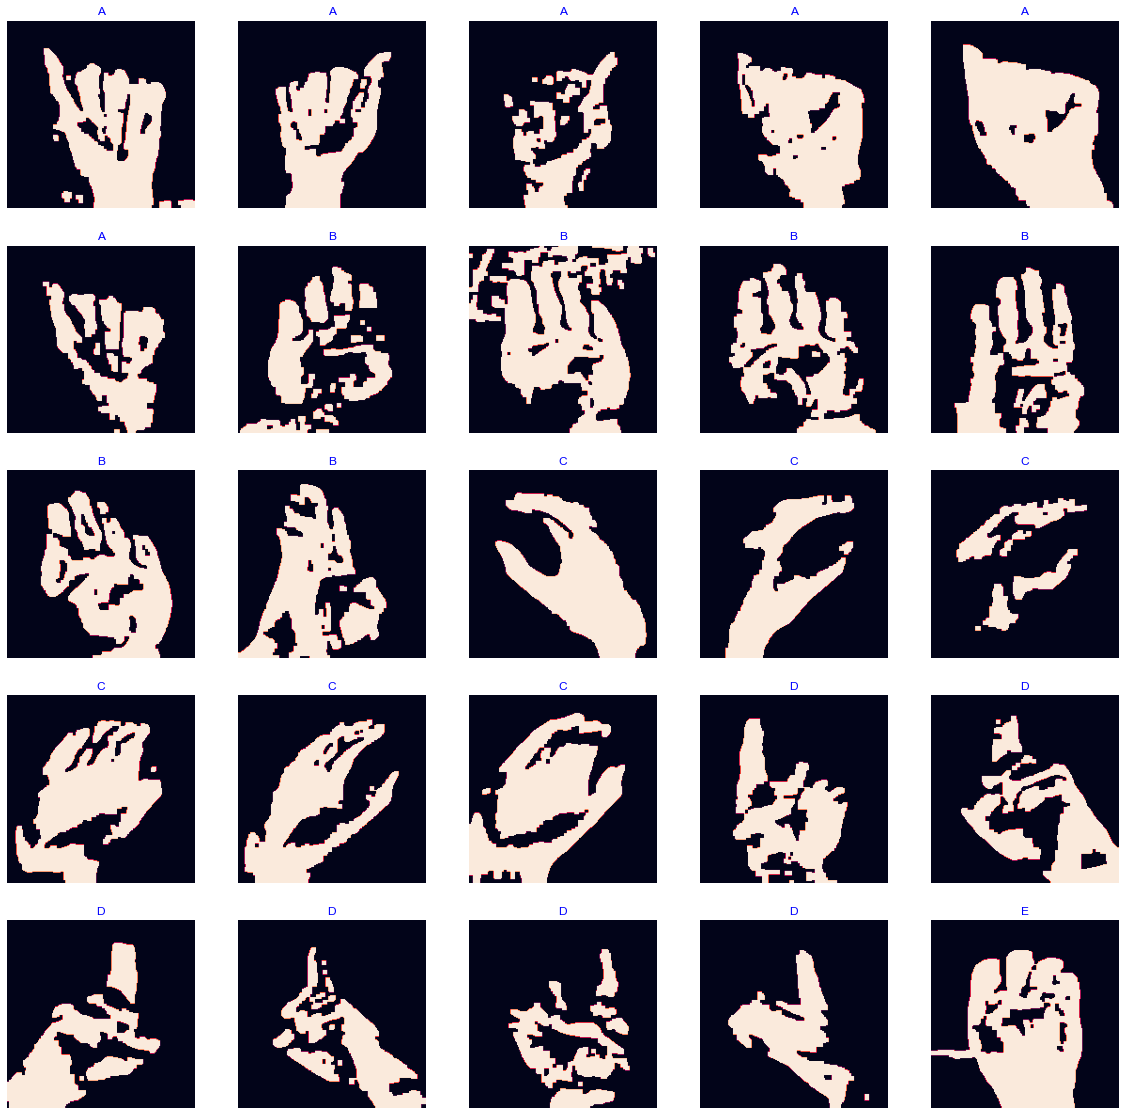

In [16]:
show_binarised_image_samples(train_gen, buffer, dimensions, lower_range_tightness, upper_range_tightness)

In [20]:
data, exit_labels = generate_kNN_database(train_gen,
                                          num_of_samples = 6,
                                          buffer = 20,
                                          dimensions = (200, 200),
                                          lower_range_tightness = 0,
                                          upper_range_tightness = 0,
                                          num_of_rows = 10)

created mask
Generated  1  samples out of  144  samplescreated mask
Generated  2  samples out of  144  samplescreated mask
Generated  3  samples out of  144  samplescreated mask
Generated  4  samples out of  144  samplescreated mask
Generated  5  samples out of  144  samplescreated mask
Generated  6  samples out of  144  samplescreated mask
Generated  7  samples out of  144  samplescreated mask
Generated  8  samples out of  144  samplescreated mask
Generated  9  samples out of  144  samplescreated mask
Generated  10  samples out of  144  samplescreated mask
Generated  11  samples out of  144  samplescreated mask
Generated  12  samples out of  144  samplescreated mask
Generated  13  samples out of  144  samplescreated mask
Generated  14  samples out of  144  samplescreated mask
Generated  15  samples out of  144  samplescreated mask
Generated  16  samples out of  144  samplescreated mask
Generated  17  samples out of  144  samplescreated mask
Generated  18  samples out of  144  samplesc

In [18]:
test_data, test_exit_labels = generate_kNN_database(test_gen,
                                          num_of_samples = 40,
                                          buffer = 20,
                                          dimensions = (200, 200),
                                          lower_range_tightness = 0,
                                          upper_range_tightness = 0,
                                          num_of_rows = 10)

created mask
Generated  1  samples out of  960  samplescreated mask
Generated  2  samples out of  960  samplescreated mask
Generated  3  samples out of  960  samplescreated mask
Generated  4  samples out of  960  samplescreated mask
Generated  5  samples out of  960  samplescreated mask
Generated  6  samples out of  960  samplescreated mask
Generated  7  samples out of  960  samplescreated mask
Generated  8  samples out of  960  samplescreated mask
Generated  9  samples out of  960  samplescreated mask
Generated  10  samples out of  960  samplescreated mask
Generated  11  samples out of  960  samplescreated mask
Generated  12  samples out of  960  samplescreated mask
Generated  13  samples out of  960  samplescreated mask
Generated  14  samples out of  960  samplescreated mask
Generated  15  samples out of  960  samplescreated mask
Generated  16  samples out of  960  samplescreated mask
Generated  17  samples out of  960  samplescreated mask
Generated  18  samples out of  960  samplesc

In [21]:
test_data.shape

(960, 100)

In [23]:
data_path = r'../dataset/SyntheticASLAlphabet-kNN/defining_dataset/'
np.save(data_path + 'defining_dataset_features', data)
np.save(data_path + 'defining_dataset_labels', exit_labels)

In [25]:
for i in range(1, 21):
    directory = str(i) + 'x' + str(i) + ' grid'
    parent_dir =  r'../dataset/SyntheticASLAlphabet-kNN/defining_dataset/'
    path = os.path.join(parent_dir, directory)
    
    os.mkdir(path)
    
    print("Directory '% s' created" % directory)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '../dataset/SyntheticASLAlphabet-kNN/defining_dataset/1x1 grid'

In [ ]:
for i in range(1, 21):
    print('making ' + str(i) + 'x' + str(i) + ' grid')
    data, exit_labels = generate_kNN_database(train_gen,
                                          num_of_samples = 6,
                                          buffer = 20,
                                          dimensions = (200, 200),
                                          lower_range_tightness = 0,
                                          upper_range_tightness = 0,
                                          num_of_rows = i)
    
#     test_data, test_exit_labels = generate_kNN_database(test_gen,
#                                       num_of_samples = 40,
#                                       buffer = 20,
#                                       dimensions = (200, 200),
#                                       lower_range_tightness = 0,
#                                       upper_range_tightness = 0,
#                                       num_of_rows = i)

    data_path = r'../dataset/Synthetic ASL Alphabet - kNN/defining_dataset/' + str(i) + 'x' + str(i) + ' grid/'
    np.save(data_path + 'defining_dataset_features', data)
    np.save(data_path + 'defining_dataset_labels', exit_labels)
    
#     np.save(data_path + 'test_dataset_features', test_data)
#     np.save(data_path + 'test_dataset_labels', test_exit_labels)

making 1x1 grid
created mask
Generated  1  samples out of  144  samplescreated mask
Generated  2  samples out of  144  samplescreated mask
Generated  3  samples out of  144  samplescreated mask
Generated  4  samples out of  144  samplescreated mask
Generated  5  samples out of  144  samplescreated mask
Generated  6  samples out of  144  samplescreated mask
Generated  7  samples out of  144  samplescreated mask
Generated  8  samples out of  144  samplescreated mask
Generated  9  samples out of  144  samplescreated mask
Generated  10  samples out of  144  samplescreated mask
Generated  11  samples out of  144  samplescreated mask
Generated  12  samples out of  144  samplescreated mask
Generated  13  samples out of  144  samplescreated mask
Generated  14  samples out of  144  samplescreated mask
Generated  15  samples out of  144  samplescreated mask
Generated  16  samples out of  144  samplescreated mask
Generated  17  samples out of  144  samplescreated mask
Generated  18  samples out o

In [ ]:
for i in range(1, 21):
    print('making ' + str(i) + 'x' + str(i) + ' grid')
#     data, exit_labels = generate_kNN_database(train_gen,
#                                           num_of_samples = 6,
#                                           buffer = 20,
#                                           dimensions = (200, 200),
#                                           lower_range_tightness = 0,
#                                           upper_range_tightness = 0,
#                                           num_of_rows = i)
    
    test_data, test_exit_labels = generate_kNN_database(test_gen,
                                      num_of_samples = 40,
                                      buffer = 20,
                                      dimensions = (200, 200),
                                      lower_range_tightness = 0,
                                      upper_range_tightness = 0,
                                      num_of_rows = i)
    print('generated ' + str(i) + 'x' + str(i) + 'grid')

    data_path = r'../dataset/Synthetic ASL Alphabet - kNN/defining_dataset/' + str(i) + 'x' + str(i) + ' grid/'
#     np.save(data_path + 'defining_dataset_features', data)
#     np.save(data_path + 'defining_dataset_labels', exit_labels)
    
    np.save(data_path + 'test_dataset_features', test_data)
    print('saved test features')
    np.save(data_path + 'test_dataset_labels', test_exit_labels)
    print('saved test labels')

making 1x1 grid


NameError: name 'test_gen' is not defined

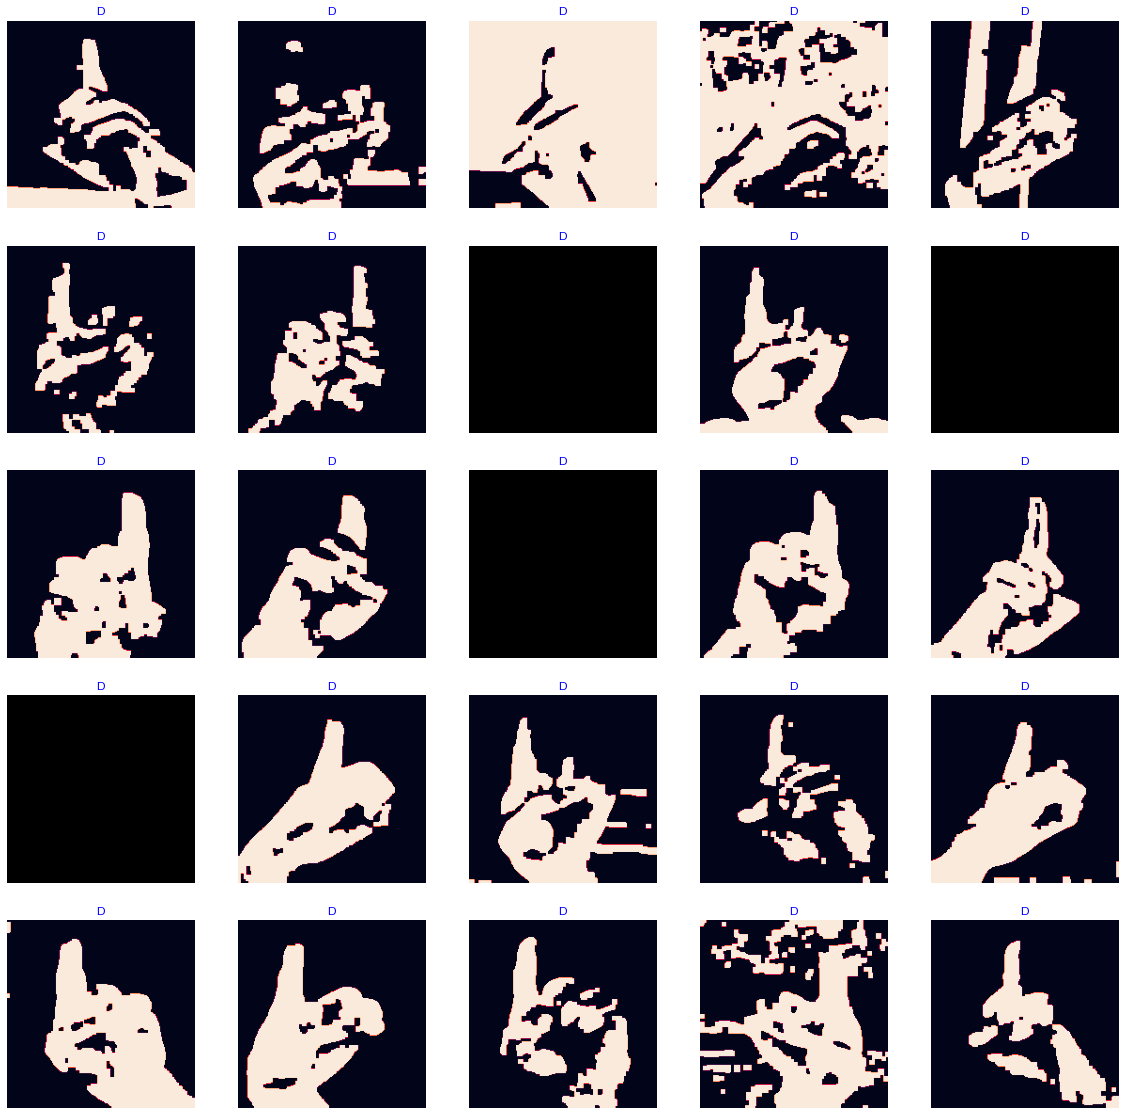

In [24]:
show_binarised_image_samples(test_gen, buffer, dimensions, lower_range_tightness, upper_range_tightness)